# Variational AutoEncoder

## Import statements + Device

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from utils import print_np_array_properties, imshow_batch, imshow_with_encoded_labels
from tqdm.notebook import tqdm, trange
import warnings
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available Device: {device}')

Available Device: cuda


## Dataset

### Download Dataset

In [15]:
## Define preprocessing transformation applied to data
transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_data = datasets.CelebA(
    root='data',
    split='train',
    download=True,
    transform=transform)

valid_data = datasets.CelebA( 
    root='data',
    split='valid',
    download=True,
    transform=transform)

test_data = datasets.CelebA( 
    root='data',
    split='test',
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Prep data

torch.Size([64, 3, 218, 178])


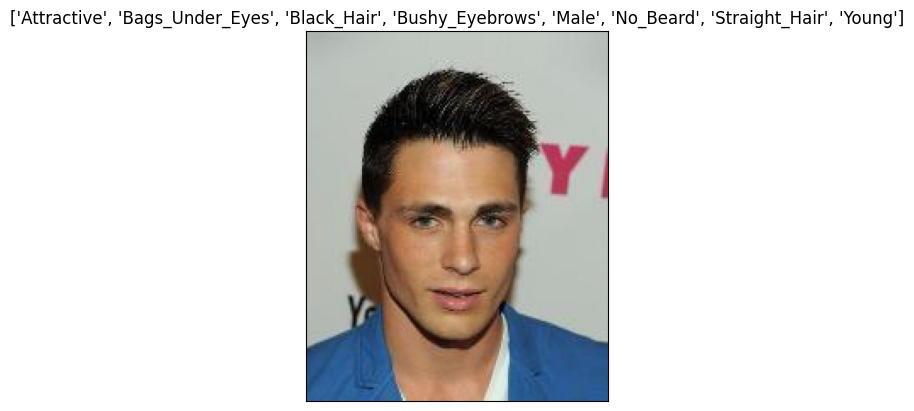

In [16]:
num_workers = 0
# how many samples per batch to load
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

classes = ['5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes','Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
        'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
        'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# for i in np.arange(5):
    
#     fig = plt.figure()
    
#     ax = fig.add_subplot(xticks=[], yticks=[])
#     plt.imshow(images[i].permute(1, 2, 0))
    
#     attr = [classes[idx] for idx, attr in enumerate(label[i]) if attr]
#     ax.set_title(attr)

imshow_with_encoded_labels(1, images, labels, classes)

    

## Convolutional Autoencoder Architecture

In [4]:
class ConvAE(nn.Module):
    def __init__(self):
        
        super(ConvAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
            
            
    def forward(self,x):
        z = self.encoder(x)
        x = self.decoder(z)
        
        return x, z

### Define Model and optimizer

In [5]:
model = ConvAE().to(device)

print(model)

x,z= model(images[i].to(device))

print_np_array_properties(z)
print_np_array_properties(x)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
=============== np array Properties =============

np array:
 tensor([[[0.0896, 0.0918, 0.0933,  ..., 0.0911, 0.0911, 0.0911],
         [0.0956, 0.0916, 0.0925,  ..., 0.0914, 0.0914, 0.0915],
         [0.0947, 0.0917, 0.0930,  ..., 0.0938, 0.0938, 0.0940],
         ...,
         [0.1580, 0.2106, 0.1238,  ..., 0.0988, 0.0937, 0.0941],
         [0.1601, 0.1790, 0.1188,  ..., 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.003340 	Validation Loss: 0.001876
Validation loss decreased (inf --> 0.001876).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.001797 	Validation Loss: 0.001751
Validation loss decreased (0.001876 --> 0.001751).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.001673 	Validation Loss: 0.001676
Validation loss decreased (0.001751 --> 0.001676).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.001618 	Validation Loss: 0.001522
Validation loss decreased (0.001676 --> 0.001522).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.001590 	Validation Loss: 0.001545


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.001556 	Validation Loss: 0.002056


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.001530 	Validation Loss: 0.001560


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.001517 	Validation Loss: 0.001457
Validation loss decreased (0.001522 --> 0.001457).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.001497 	Validation Loss: 0.001434
Validation loss decreased (0.001457 --> 0.001434).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.001481 	Validation Loss: 0.001593


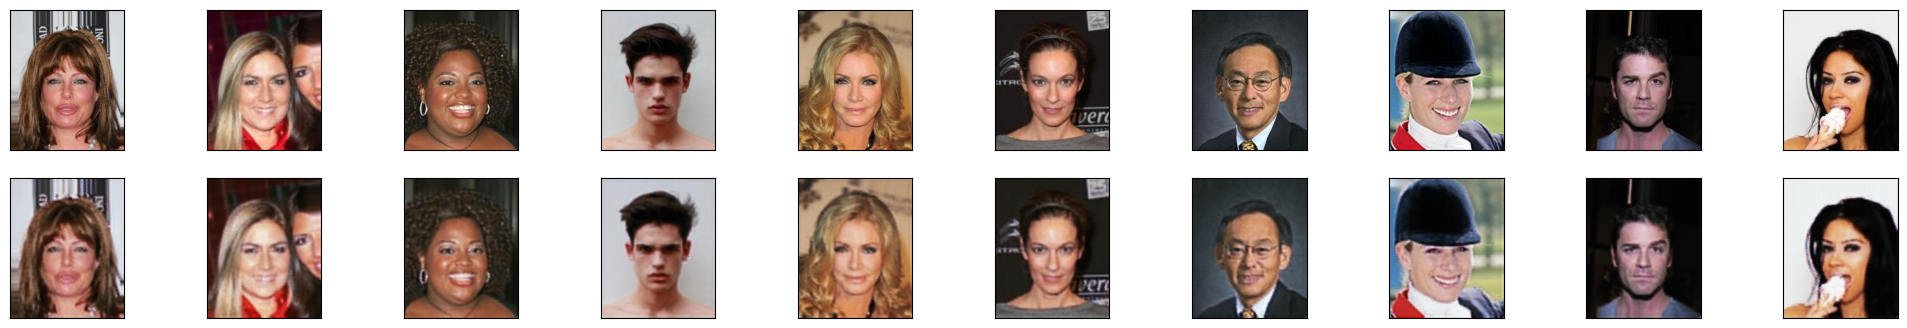

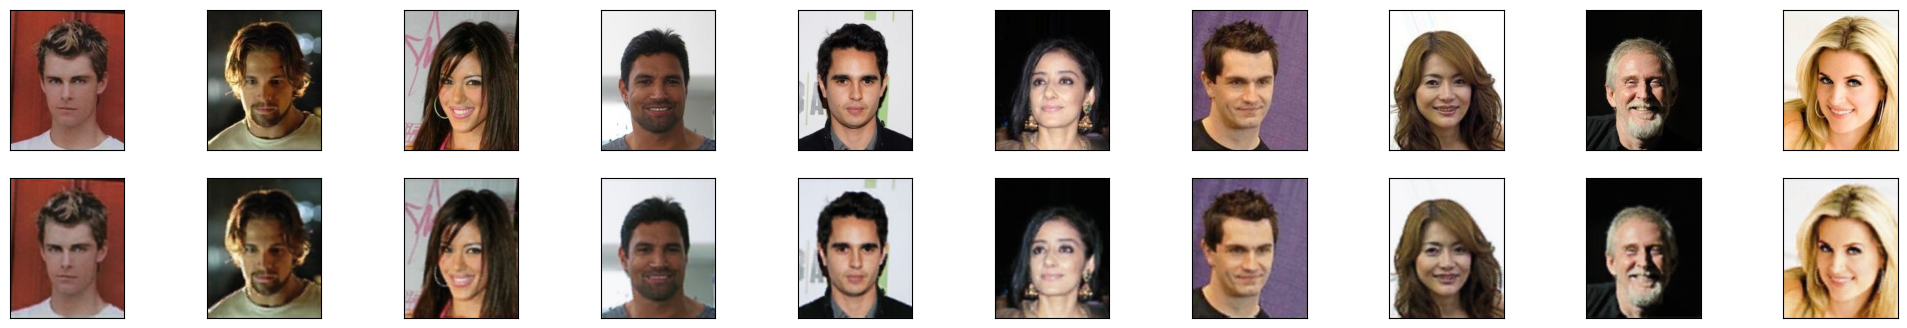

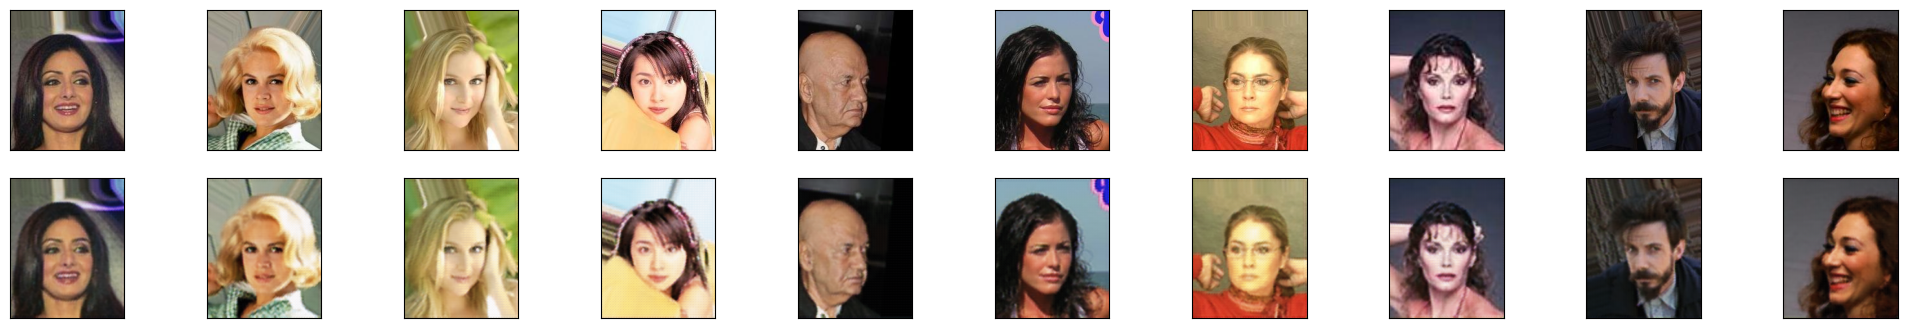

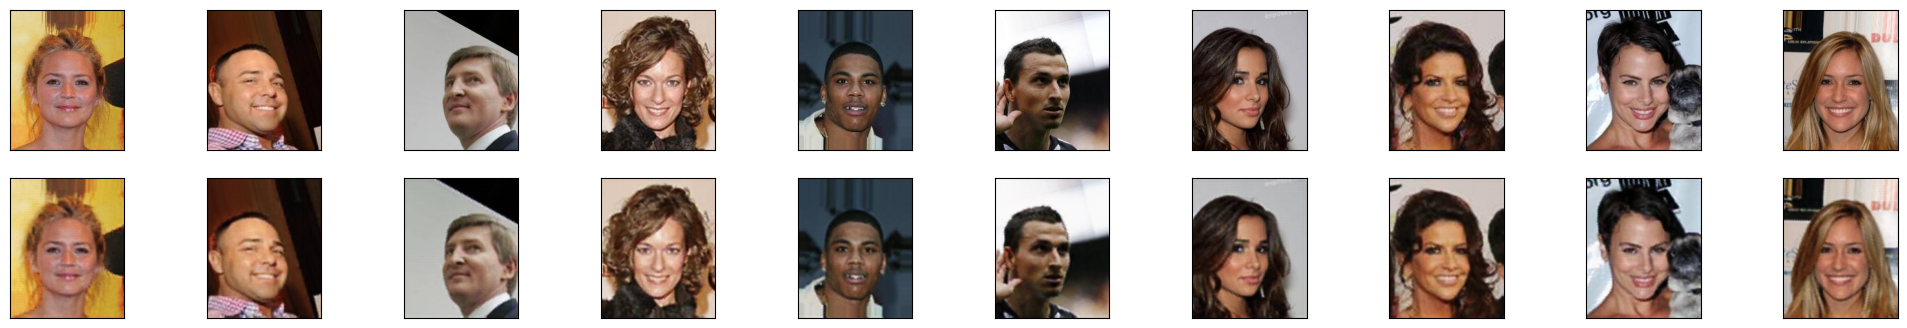

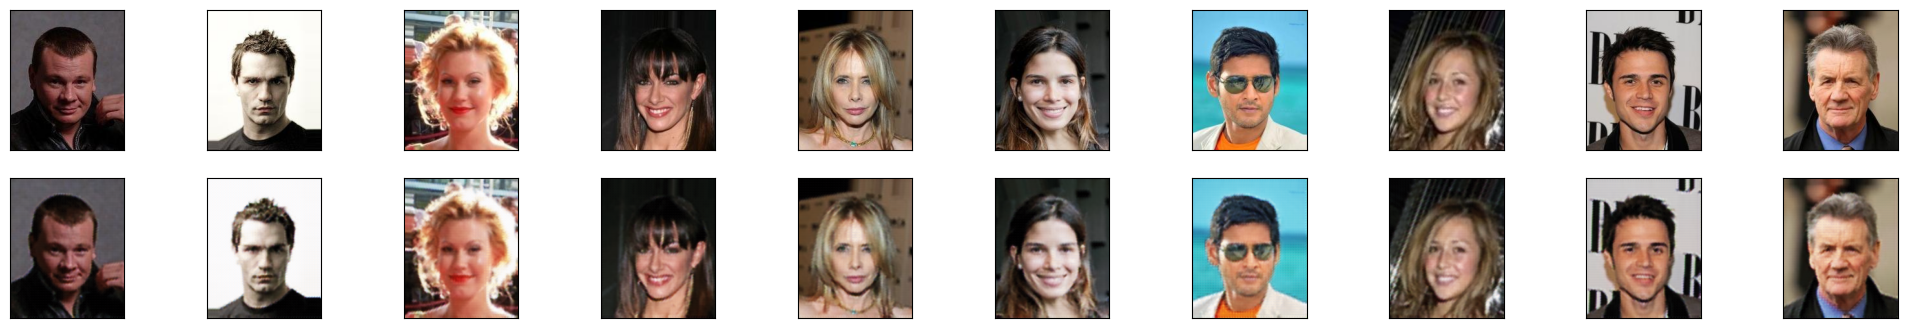

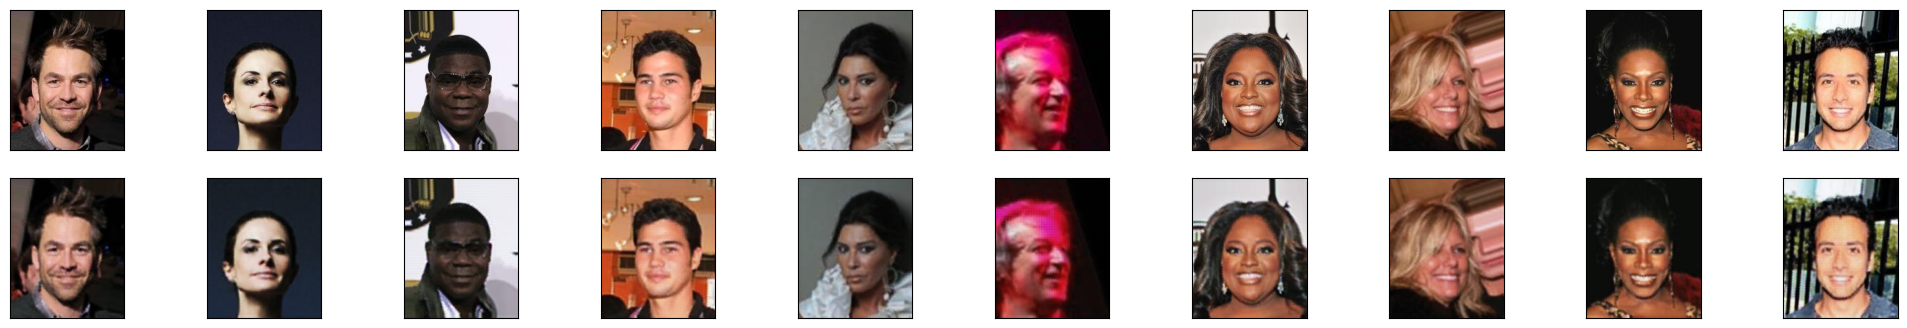

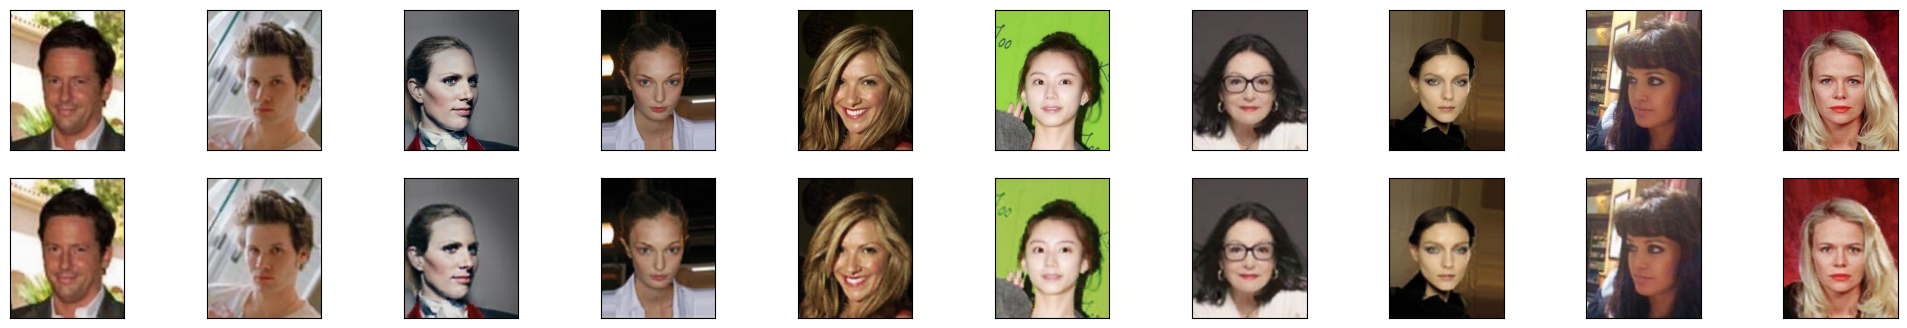

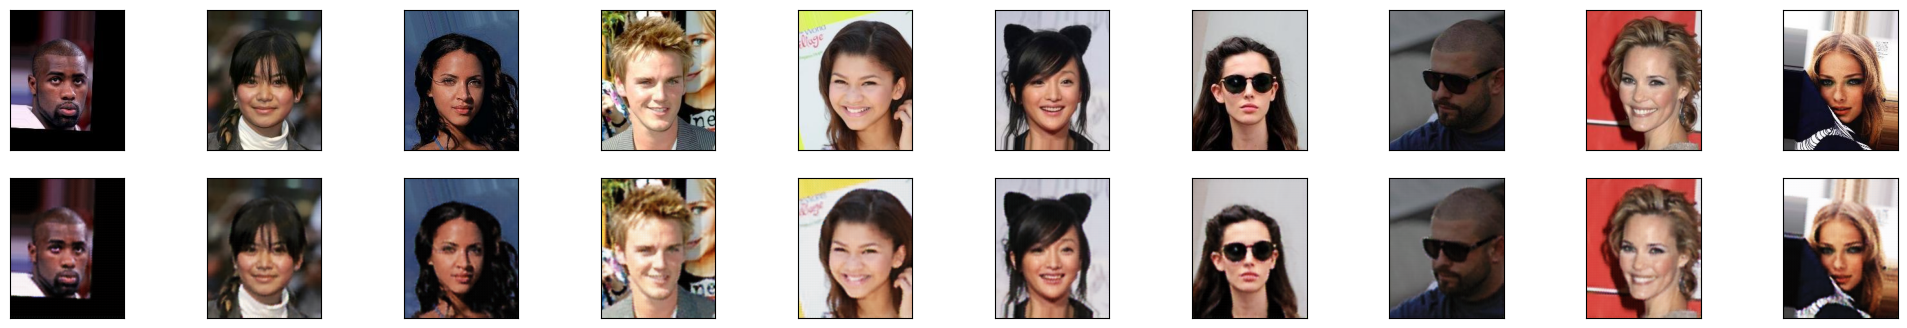

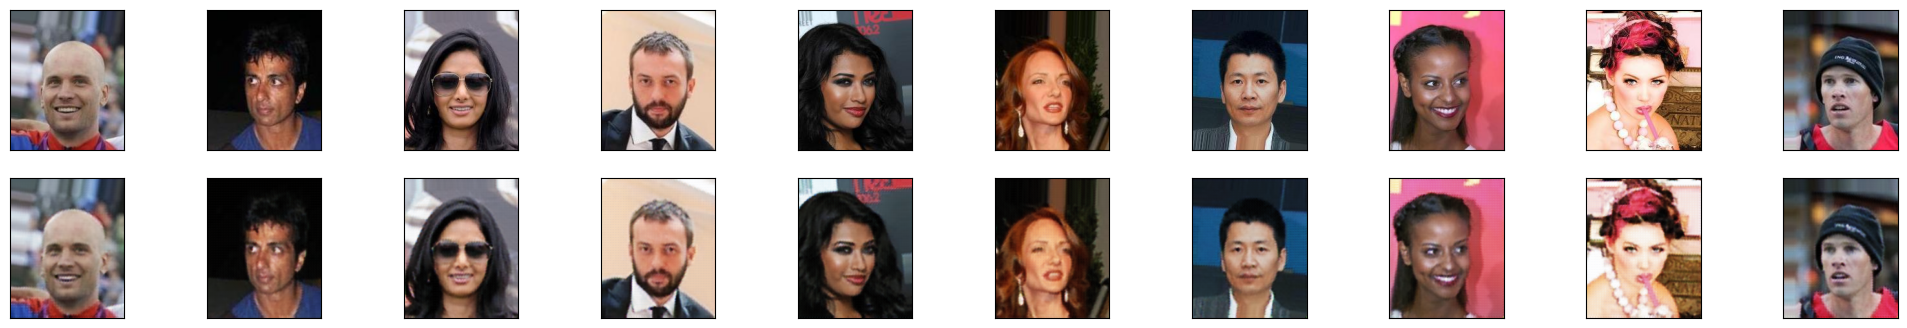

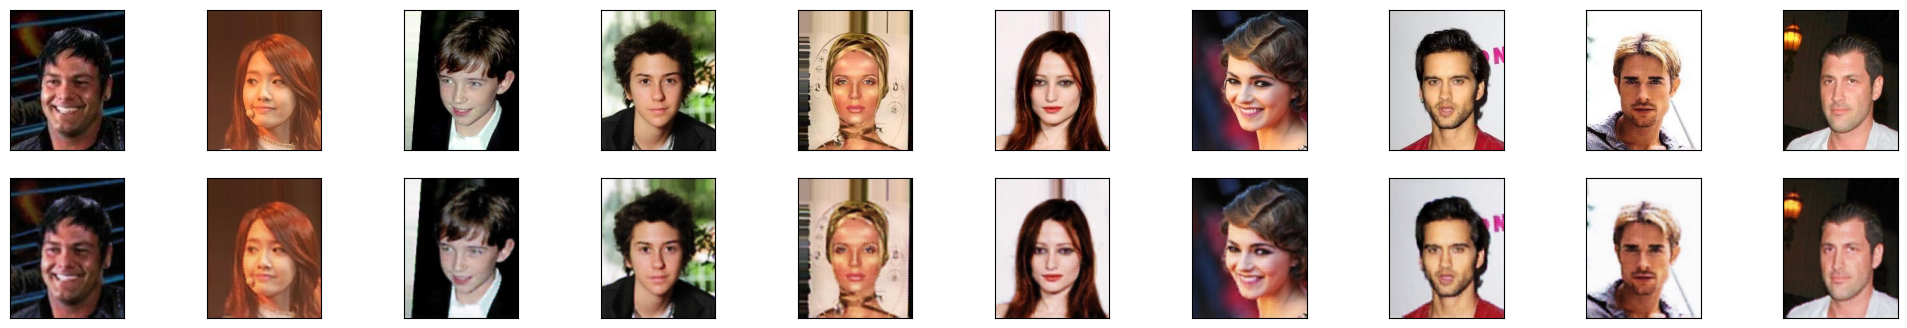

In [6]:
n_epochs=10

valid_loss_min = np.Inf

for epoch in trange(1, n_epochs+1):
    
    train_loss=0.0
    valid_loss=0.0
    
    ## Training Step
    model.train()
    for images, _ in tqdm(train_loader):
        
        images = images.to(device)
        
        optimizer.zero_grad() # clar the gradients of all optimized variables
        x,z = model(images) # Forward pass
        
        loss = loss_func(x, images) # calculate loss of the forward pass
        
        loss.backward() #calculate gradients based on the loss
        
        optimizer.step() # update weights
        
        train_loss += loss.item()*images.size(0)
    ## Validation Step
    
    model.eval()
    for images, _ in tqdm(valid_loader):
        images = images.to(device)
        
        x,z = model(images) # forward pass
        
        loss = loss_func(x, images)
        
        valid_loss += loss.item() * images.size(0)
    
    # calculate Average loss
    train_loss = train_loss/len(train_loader.dataset) 
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    #Print progress statement
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    #Test after ach epoch
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images[:10]

    # get sample outputs
    output, _ = model(images.to(device))
    # prep images for display
    images = images.numpy()

    # output is resized into a batch of iages
    output = output.to('cpu').view(10, 3, 218, 178)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.transpose(img, (1,2,0)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
    
    #Save model with the lowest validation loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), './data/ConvAE_celebA.pt')
        valid_loss_min = valid_loss

### Test output

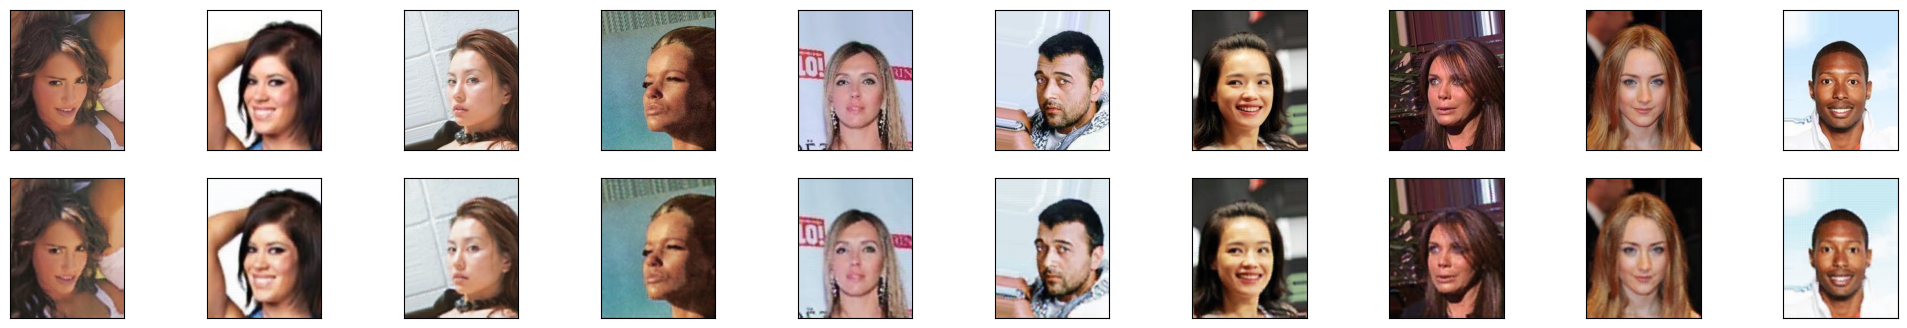

In [8]:
model.load_state_dict(torch.load('./data/ConvAE_celebA.pt'))

# obtain one batch of test images
dataiter = iter(test_loader)
images, _ = next(dataiter)


images = images[:10]

# get sample outputs
output, _ = model(images.to(device))
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.to('cpu').view(10, 3, 218, 178)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.transpose(img, (1,2,0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Variational Autoencoder Architecture

In [17]:
class VAE(nn.Module):
    def __init__(self, latent_size = 128):
        
        super(VAE, self).__init__()
        
        self.mu=None
        self.logvar=None
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.mu_fc = nn.Linear(8*54*44, self.latent_size)
        
        self.logvar_fc = nn.Linear(8*54*44, self.latent_size)
        
        self.z_fc = nn.Linear(self.latent_size, 8*54*44) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)        
        mu = self.mu_fc(x)
        logvar = self.logvar_fc(x)
        
        return mu, logvar

    def reparam(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        z = mu + eps * std
        return z
    
    
    def decode(self, z):
        
        z = self.z_fc(z)
        
        z = z.view(z.size(0), 8, 54, 44)
        
        x = self.decoder(z)
        
        return x
            
    def forward(self,x):
        self.mu, self.logvar = self.encode(x)
        z = self.reparam(self.mu, self.logvar)
        x = self.decode(z)
        
        return x, self.mu, self.logvar

def vae_loss(x_out, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(x_out, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

### Define Model and optimizer

In [18]:
model = VAE().to(device)

print(model)

# print_np_array_properties(images)

x, mu, logvar = model(images.to(device))


print_np_array_properties(x, 'reconstructed x')
print_np_array_properties(mu, 'mu')
print_np_array_properties(logvar, 'logvar')


loss_func = vae_loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mu_fc): Linear(in_features=19008, out_features=128, bias=True)
  (logvar_fc): Linear(in_features=19008, out_features=128, bias=True)
  (z_fc): Linear(in_features=128, out_features=19008, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
=============== reconstructed x Properties =============

reconstructed x:
 tensor([[[[0.5420, 0.5396, 0.5396,  ..., 0.5415, 0.5495, 0.5351],
          [0.5250, 0.5387, 0.5256,  

### Training

In [ ]:
n_epochs=30

valid_loss_min = np.Inf

for epoch in trange(1, n_epochs+1):
    
    train_loss=0.0
    valid_loss=0.0
    
    ## Training Step
    model.train()
    for images, _ in tqdm(train_loader):
        
        images = images.to(device)
        
        optimizer.zero_grad() # clar the gradients of all optimized variables
        x_out, mu, logvar = model(images) # Forward pass
        
        loss = loss_func(x_out, images, mu, logvar) # calculate loss of the forward pass
        
        loss.backward() #calculate gradients based on the loss
        
        optimizer.step() # update weights
        
        train_loss += loss.item()*images.size(0)
    ## Validation Step
    
    model.eval()
    for images, _ in tqdm(valid_loader):
        images = images.to(device)
        
        x_out, mu, logvar = model(images) # forward pass
        
        loss = loss_func(x_out, images, mu, logvar)
        
        valid_loss += loss.item() * images.size(0)
    
    # calculate Average loss
    train_loss = train_loss/len(train_loader.dataset) 
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    #Print progress statement
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    #Test after ach epoch
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    images = images[:10]

    # get sample outputs
    output, _, _ = model(images.to(device))
    # prep images for display
    images = images.numpy()

    # output is resized into a batch of iages
    output = output.to('cpu').view(10, 3, 218, 178)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.transpose(img, (1,2,0)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
    
    #Save model with the lowest validation loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), './data/VAE_celebA.pt')
        valid_loss_min = valid_loss

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 4969570.806902 	Validation Loss: 4966020.623710
Validation loss decreased (inf --> 4966020.623710).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

### Sample Distribution p(Z) to generate a new face

In [ ]:
model.load_state_dict(torch.load('./data/VAE_celebA.pt'))

        
batch_size = 100
latent_size = model.latent_size
z = torch.randn(batch_size, latent_size).to(device)

print_np_array_properties(z)

# generate an image from the random latent vector using the decoder
model.eval()
with torch.no_grad():
    images = model.decode(z)
    
images = images.to('cpu')

imshow_batch(batch_size, images)
